# KANs to solve PDE 

reference: https://kindxiaoming.github.io/pykan/Example/Example_6_PDE_interpretation.html and https://kindxiaoming.github.io/pykan/Example/Example_7_PDE_accuracy.html (original author of the KAN's)

Before run the notebook, please create a separate ennvironment, because the library is still instable.

```
conda create --name pykan-env python=3.9.7
conda activate pykan-env
pip install git+https://github.com/KindXiaoming/pykan.git  
pip install -r pykan_env_requirements.txt
```

In [2]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
dim = 2
np_i = 51 # number of interior points (along each dimension)
np_b = 51 # number of boundary points (along each dimension)
ranges = [-1, 1]


def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])

# interior
sampling_mode = 'mesh' # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1

x_i = x_i.to(device)

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

x_b = x_b.to(device)

alpha = 0.01
log = 1


grids = [5,10,20]
steps = 50

pde_losses = []
bc_losses = []
l2_losses = []

for grid in grids:
    if grid == grids[0]:
        model = KAN(width=[2,2,1], grid=grid, k=3, seed=1, device=device)
        model = model.speed()
    else:
        model.save_act = True
        model.get_act(x_i)
        model = model.refine(grid)
        model = model.speed()
    model = model.to(device)
    def train():
        optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        pbar = tqdm(range(steps), desc='description', ncols=100)

        for _ in pbar:
            def closure():
                global pde_loss, bc_loss
                optimizer.zero_grad()
                # interior loss
                sol = sol_fun(x_i)
                sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
                sol_D1 = sol_D1_fun(x_i)
                sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
                lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
                source = source_fun(x_i)
                pde_loss = torch.mean((lap - source)**2)

                # boundary loss
                bc_true = sol_fun(x_b)
                bc_pred = model(x_b)
                bc_loss = torch.mean((bc_pred-bc_true)**2)

                loss = alpha * pde_loss + bc_loss
                loss.backward()
                return loss

            if _ % 5 == 0 and _ < 20:
                model.update_grid_from_samples(x_i)

            optimizer.step(closure)
            sol = sol_fun(x_i)
            loss = alpha * pde_loss + bc_loss
            l2 = torch.mean((model(x_i) - sol)**2)

            if _ % log == 0:
                pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

            pde_losses.append(pde_loss.cpu().detach().numpy())
            bc_losses.append(bc_loss.cpu().detach().numpy())
            l2_losses.append(l2.cpu().detach().numpy())


    train()

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.12e+00 | bc loss: 1.86e-03 | l2: 3.09e-03 : 100%|███████| 50/50 [00:22<00:00,  2.21it/s]
pde loss: 5.57e-01 | bc loss: 5.23e-04 | l2: 1.02e-03 : 100%|███████| 50/50 [00:22<00:00,  2.20it/s]
pde loss: 1.00e-01 | bc loss: 3.84e-05 | l2: 7.36e-05 : 100%|███████| 50/50 [00:21<00:00,  2.33it/s]


In [4]:
model.save_act = True
model

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

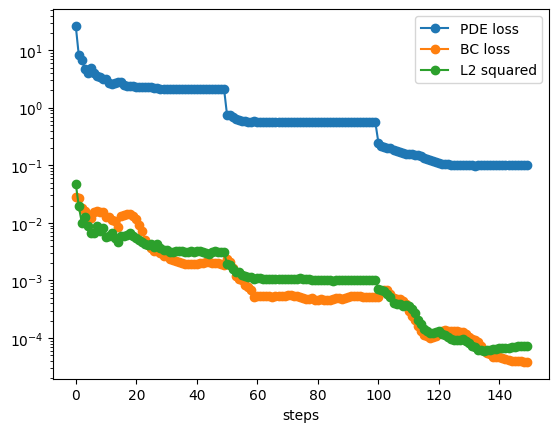

In [5]:
plt.plot(pde_losses, marker='o')
plt.plot(bc_losses, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['PDE loss', 'BC loss', 'L2 squared'])

In [6]:
model.get_act(x_i)

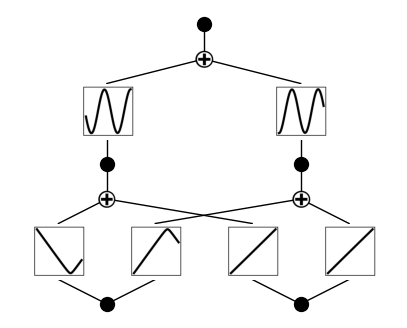

In [7]:
model.plot(beta=100)

saving model version 0.3


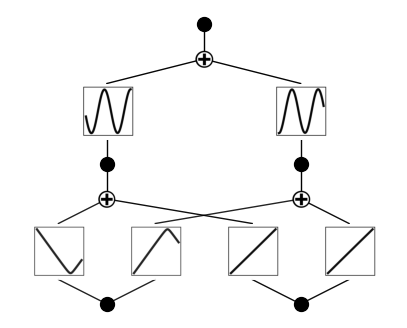

In [9]:
model.prune()
model.plot()

In [10]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula,6)

fixing (0,0,0) with abs, r2=0.9994537830352783, c=3
fixing (0,0,1) with abs, r2=0.999456524848938, c=3
fixing (0,1,0) with x, r2=0.9999959468841553, c=1
fixing (0,1,1) with x, r2=0.9999963045120239, c=1
fixing (1,0,0) with x, r2=3.210408294762601e-06, c=1
fixing (1,1,0) with x, r2=5.930844054091722e-06, c=1


0.002076*x_2 - 0.000254*Abs(4.6*x_1 - 2.312) + 0.000104*Abs(8.25544*x_1 - 4.15048) + 0.000329